<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Day_8_Beginner_tutorial_on_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: 30th Jan 2020
 
This is the Pytorch tutorial by Jeremy Howard. Original Source: 


https://pytorch.org/tutorials/beginner/nn_tutorial.html

-------------------------

Loading directories using pathlib. Pathlib is now part of the Python 3 standard libraries 



In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

# The file is downloaded as a zipped pickle 
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


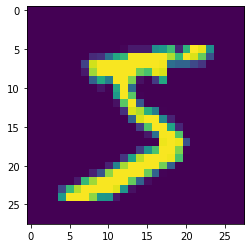

In [3]:
# Each image is a 28x28 numpy array which has been flattened. This will be reshaped to a gray scale image

from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28))) #, cmap="gray")
print(x_train.shape)

In [4]:
# Since pytorch uses torch.tensors we will convert these numpy arrays 

import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

In [5]:
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [0]:
# Initializing via Xavier initalization 1/sqrt(n)

import math

weights = torch.randn(784, 10) / math.sqrt(784)

In [7]:
weights.requires_grad_()  # This cause PyTorch to record all the operations done on the tensor & claculate the gradient during back-propogation
                          # The _ indicates that operation is done in-place 
                          # This is done after initalization so that the initialization step is not included during back-propogation

tensor([[-0.0332, -0.0217,  0.0023,  ..., -0.0916,  0.0100,  0.0480],
        [ 0.0305, -0.0128, -0.0231,  ..., -0.0303,  0.0481, -0.0223],
        [-0.0390,  0.0131, -0.0079,  ..., -0.0130,  0.0402, -0.0251],
        ...,
        [-0.0017,  0.0172,  0.0227,  ..., -0.0235,  0.0238, -0.0360],
        [ 0.0348,  0.0061, -0.0230,  ...,  0.0713, -0.0379, -0.0309],
        [-0.0128,  0.0170,  0.0099,  ..., -0.0373, -0.0639, -0.0301]],
       requires_grad=True)

In [0]:
bias = torch.zeros(10, requires_grad=True)

In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [10]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
#preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.6632, -2.5091, -2.1814, -2.9018, -2.5293, -2.1376, -2.3095, -1.9985,
        -2.1772, -2.0005], grad_fn=<SelectBackward>) torch.Size([64, 10])


The preds tensor contains the tensor values & the gradient function. This will then beused to calculate the back propagation 

In [0]:
# We define the loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [12]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3307, grad_fn=<NegBackward>)


In [0]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [14]:
print(accuracy(preds, yb))

tensor(0.1406)


In [0]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NegBackward>) tensor(1.)


** Now by using Pytorch nn class, we redefine the loss function, using the inbuilt F.cross_entropy**

In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy # The activation function is replaced by inbuilt torch.nn.functional.cross_entropy

def model(xb):
    return xb @ weights + bias

In [25]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward>) tensor(1.)


In [0]:
# Now we will recreate the training loop in pytorch 

from torch import nn

class Mnist_Logistic(nn.Module): # we are sub-classing nn.Module which is a base class for ll neural network modules 
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [0]:
model = Mnist_Logistic() # First instantiating the object. This is different from the previous implementation where we had created a function'

In [29]:
print(loss_func(model(xb), yb))

tensor(2.4794, grad_fn=<NllLossBackward>)


In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [32]:
print(loss_func(model(xb), yb))

tensor(0.0822, grad_fn=<NllLossBackward>)


In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [34]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2590, grad_fn=<NllLossBackward>)


In [35]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


In [37]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.1780, grad_fn=<NllLossBackward>)


In [38]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>)


Converting  train  to a tensordataset

In [0]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [41]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward>)


Now we refactor the code to a Dataset loader. This class created mini-batches on its own. 

```train_ds[i * bs: i * bs + bs]``` << - This is not required 

In [0]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train) # Converting to tensordataset
train_dl = DataLoader(train_ds, batch_size=bs) # and then initializing a dataloader class

In [43]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0797, grad_fn=<NllLossBackward>)


In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [45]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3383)
1 tensor(0.2905)


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [0]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

**After defining the above functions. We get the *famous* 3 LINES OF CODE**

In [49]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.304442338180542
1 0.29266126551628113


In [0]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [51]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.28648542103767394
1 0.2212788229227066


In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [53]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4236139154434204
1 0.28290433728694914


In [0]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)    # The Wrapped dataloader class , pre-processes the image to a 28x28 vector 
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [0]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), # Average adaptive pooling allows us to define the output tensor of our choice 
                             # so we can use any input tensor of choice
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [61]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31927940299510954
1 0.24793808761835098


In [62]:
print(torch.cuda.is_available())

False


In [0]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu") #  Creating a device objct which points to a GPU, if it exists

In [0]:
# The preprocessing is updated to move the tensors to a GPU (if available)

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)



In [0]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [66]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.20839096862077713
1 0.1982756784558296
